<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading MNIST Dataset
----------------------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.7kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.08MB/s]


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size = 5, in_channels = 1, out_channels = 6)
        self.conv2 = torch.nn.Conv2d(kernel_size = 5, in_channels = 6, out_channels = 16)
        self.conv3 = torch.nn.Conv2d(kernel_size = 4, in_channels = 16, out_channels = 120)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(120, 84)
        self.linear2 = torch.nn.Linear(84, 10)

        # TODO: add missing layers

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.squeeze(-1).squeeze(-1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        # TODO: add missing processing

        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3033318519592285
epoch: 0 batch: 1 current batch loss: 2.296571731567383
epoch: 0 batch: 2 current batch loss: 2.2863125801086426
epoch: 0 batch: 3 current batch loss: 2.281834840774536
epoch: 0 batch: 4 current batch loss: 2.2730770111083984
epoch: 0 batch: 5 current batch loss: 2.2596588134765625
epoch: 0 batch: 6 current batch loss: 2.2468154430389404
epoch: 0 batch: 7 current batch loss: 2.228208065032959
epoch: 0 batch: 8 current batch loss: 2.206906795501709
epoch: 0 batch: 9 current batch loss: 2.1800127029418945
epoch: 0 batch: 10 current batch loss: 2.14513897895813
epoch: 0 batch: 11 current batch loss: 2.110630512237549
epoch: 0 batch: 12 current batch loss: 2.066464900970459
epoch: 0 batch: 13 current batch loss: 2.0161595344543457
epoch: 0 batch: 14 current batch loss: 1.9539499282836914
epoch: 0 batch: 15 current batch loss: 1.87421452999115
epoch: 0 batch: 16 current batch loss: 1.8108649253845215
epoch: 0 batch: 17

# Testing
----------------------

In [7]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9831


# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

Step 0, Loss: 5.1692, Confidence: [0.006, 0.001, 0.008, 0.051, 0.0, 0.121, 0.001, 0.003, 0.521, 0.001]
Step 50, Loss: 0.0315, Confidence: [0.964, 0.962, 0.994, 0.98, 0.965, 0.992, 0.966, 0.98, 0.986, 0.904]
Step 100, Loss: 0.0121, Confidence: [0.982, 0.984, 0.996, 0.989, 0.989, 0.995, 0.983, 0.993, 0.993, 0.976]
Step 150, Loss: 0.0080, Confidence: [0.987, 0.99, 0.997, 0.993, 0.992, 0.996, 0.988, 0.995, 0.996, 0.986]
Step 200, Loss: 0.0058, Confidence: [0.991, 0.993, 0.998, 0.995, 0.994, 0.997, 0.991, 0.997, 0.997, 0.99]
Step 250, Loss: 0.0045, Confidence: [0.993, 0.995, 0.998, 0.996, 0.996, 0.998, 0.993, 0.997, 0.998, 0.993]
Step 300, Loss: 0.0036, Confidence: [0.994, 0.996, 0.998, 0.997, 0.996, 0.998, 0.994, 0.998, 0.998, 0.994]
Step 350, Loss: 0.0030, Confidence: [0.995, 0.997, 0.999, 0.997, 0.997, 0.998, 0.995, 0.998, 0.998, 0.995]
Step 400, Loss: 0.0025, Confidence: [0.996, 0.997, 0.999, 0.998, 0.997, 0.999, 0.996, 0.999, 0.999, 0.996]
Step 450, Loss: 0.0022, Confidence: [0.996, 0.

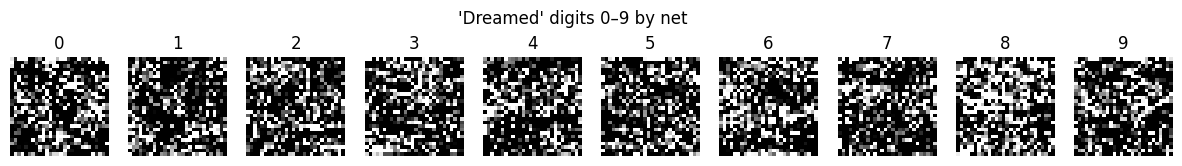

In [8]:
### TASK 1.1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# setting up network
net.eval()

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# setting target classes for images: i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# "dreaming" procedure; optimizing random gaussian input images
for step in range(3000):

    # freezing weights of the net
    optimizer.zero_grad()

    # defining loss function and optimizing
    logits = net(dreamed_inputs)
    loss = F.cross_entropy(logits, target_classes)
    loss.backward()
    optimizer.step()

    # displaying values of loss function and probabilities that i-th image is i-th digit
    if step % 50 == 0 or step == 2999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# preparing for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# vizualization of "dreamed" digits by the net
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()


lepsza widocznosc, jednak dalej problematyczna, teraz sprobujmy z l2 penalty

λ=0.001, Step 0, Loss: 4.5848, P(class): [0.0, 0.0, 0.148, 0.217, 0.0, 0.038, 0.024, 0.011, 0.281, 0.01]
λ=0.001, Step 500, Loss: 0.0028, P(class): [0.997, 0.998, 0.999, 0.999, 0.999, 0.999, 0.997, 0.999, 0.999, 0.998]
λ=0.001, Step 1000, Loss: 0.0017, P(class): [0.999, 0.999, 1.0, 1.0, 0.999, 1.0, 0.999, 1.0, 1.0, 0.999]
λ=0.001, Step 1500, Loss: 0.0014, P(class): [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0]
λ=0.001, Step 2000, Loss: 0.0013, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 2500, Loss: 0.0011, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 2999, Loss: 0.0011, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 0, Loss: 4.5938, P(class): [0.0, 0.0, 0.148, 0.217, 0.0, 0.038, 0.024, 0.011, 0.281, 0.01]
λ=0.010, Step 500, Loss: 0.0115, P(class): [0.997, 0.997, 0.999, 0.999, 0.999, 0.999, 0.997, 0.999, 0.999, 0.997]
λ=0.010, Step 1000, Loss: 0.0091, P(class): [0.998, 0.999, 1.0, 1.0, 0.99

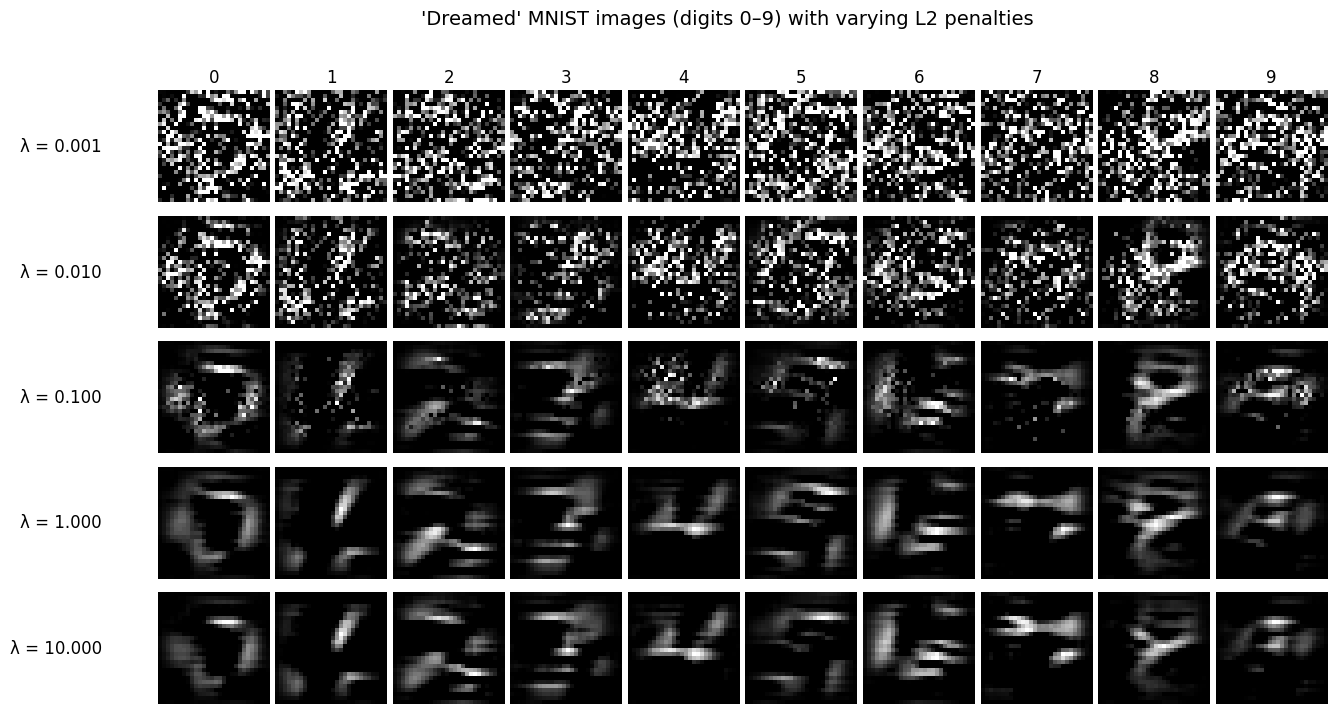

In [9]:
### TASK 1.2

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


# generating 10 random gaussian noise iamges
base_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# setting target classes for images: i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# preparing set of lambda values
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# preparing for further vizualization
fig, axs = plt.subplots(len(lambda_values), 10, figsize=(15, 8))
if len(lambda_values) == 1:
    axs = axs.unsqueeze(0)

# "dreaming" procedure for every lambda
for i, lambda_l2 in enumerate(lambda_values):

    # getting input images
    dreamed_inputs = base_inputs.clone().detach().requires_grad_(True)

    # preparing optimizer
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    # optimizing procedure (almost the same as in Problem 1)
    for step in range(3000):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        probs = F.softmax(logits, dim=1)
        target_loss = F.cross_entropy(logits, target_classes)

        # introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

        # displaying values of loss function and probabilities of "correct" classification
        if step % 500 == 0 or step == 2999:
            prob_class = probs.gather(1, target_classes.view(-1, 1))
            print(f"λ={lambda_l2:.3f}, Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in prob_class]}")

    # Vizualization section
    images = dreamed_inputs.detach().cpu().clamp(0, 1)

    for j in range(10):
        ax = axs[i, j]
        ax.imshow(images[j, 0], cmap='gray')
        ax.axis('off')

        # labeling each row with lambda
        if j == 0:
            ax.annotate(f"λ = {lambda_l2:.3f}", xy=(0, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='right', va='center', rotation=0,
                        xytext=(-40, 0), textcoords='offset points')
        if i ==0:
            ax.set_title(str(j), fontsize=12)

# Vizualization section 2
plt.suptitle("'Dreamed' MNIST images (digits 0–9) with varying L2 penalties", fontsize=14)
plt.subplots_adjust(top=0.88, left=0.12, wspace=0.05, hspace=0.1)
plt.show()


znaczna poprawa, wciaz nie idealnie